# classifier
Classifies each tweet according to the train set, which was classified by collaborators of the Infodengue project. 

Observations:
* Do not use stemming, because of the text content of tweets.
* For sklearn, check the text preprocessing
* Using tweet tokenizer from nltk
* Using only TF for preprocessing. TF-IDF won't work because observations are too short.
* baseline: random forest, logistic

16/12
* achou numero de 0.79 de recall e 0.4 de precision muito baixo
* usar shap para interpretabilidade de xgboost

usar word2vec (notebook separado)
* ref: 
    * https://github.com/fccoelho/text-mining-cientistas-sociais

In [2]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns

#import spacy

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
outputs = "../outputs/"

In [4]:
classifications = pd.read_csv(os.path.join('../outputs/from_anvil/', 'classifications_finished.csv'))

In [5]:
classifications = classifications.groupby(by='str_id').sum()
classifications['class'] = classifications['relevance'].apply(lambda x: 1 if x>=4 else 0)
classifications['class_threshold3'] = classifications['relevance'].apply(lambda x: 1 if x>=3 else 0)
classifications.reset_index(inplace=True)
classifications.rename(columns = {'str_id': 'id'}, inplace=True)

# get text from original database

In [8]:
text_data = pd.read_json(os.path.join(outputs, "tweets_filtered.json"))
text_data.rename(columns = {'_id': 'id'}, inplace=True)

In [9]:
data = pd.merge(classifications, text_data, on='id')
data.drop(columns=['tid'], inplace=True)
data

,id,relevance,class,class_threshold3,text,text_original,date
0,699069305468551169,2,0,0,Brasil tera 55 mil militares nas ruas para com...,Brasil terá 55 mil militares nas ruas para com...,2016-02-15
1,699164279472263170,3,0,1,Depois do exercito abandonar o combate aos foc...,Depois do exército abandonar o combate aos foc...,2016-02-15
2,699264346304618496,1,0,0,Farmaceuticos recebem treinamento sobre dengue...,Farmacêuticos recebem treinamento sobre dengue...,2016-02-15
3,699266282646994944,3,0,1,Farmaceuticos recebem treinamento sobre dengue...,Farmacêuticos recebem treinamento sobre dengue...,2016-02-15
4,699315864122892288,0,0,0,RT @g1: Morador do DF faz 'rap da dengue': 'Ag...,RT @g1: Morador do DF faz 'rap da dengue': 'Ag...,2016-02-15
...,...,...,...,...,...,...,...
995,1000740798114222081,0,0,0,RT @EnquetesFutebas: So eu acho que o Diogo Ba...,RT @EnquetesFutebas: Só eu acho que o Diogo Ba...,2018-05-27
996,1000763927146450944,4,1,1,"Nao recomendo ninguem a pegar Zika, serio","Não recomendo ninguém a pegar Zika, serio",2018-05-27
997,1000764889361780736,0,0,0,@_ThiagoAndrei E deixa minha zika pra traz ???...,@_ThiagoAndrei E deixa minha zika pra traz ???...,2018-05-27
998,1000841034488778752,0,0,0,kkkkkkkkk ele tem problema mas eu amo https://...,kkkkkkkkk ele tem problema mas eu amo https://...,2018-05-27


# basic exploration

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
id                  1000 non-null int64
relevance           1000 non-null int64
class               1000 non-null int64
class_threshold3    1000 non-null int64
text                1000 non-null object
text_original       1000 non-null object
date                1000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 62.5+ KB


In [11]:
data.describe()

,id,relevance,class,class_threshold3
count,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,8.387557e+17,1.166000,0.141000,0.207000
std,1.140594e+17,1.659276,0.348196,0.405358
min,6.990693e+17,0.000000,0.000000,0.000000
25%,7.094149e+17,0.000000,0.000000,0.000000
50%,8.460180e+17,0.000000,0.000000,0.000000
75%,9.829813e+17,2.000000,0.000000,0.000000
max,1.000886e+18,6.000000,1.000000,1.000000


# check if data is unbalanced

**Data is unbalanced!**

### Threshold 4
fazer undersamplig

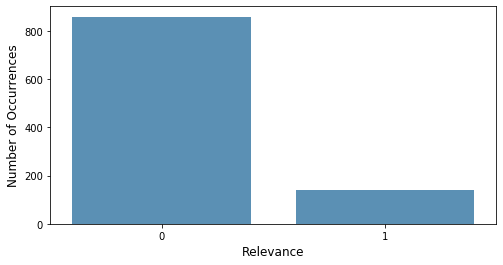

In [12]:
color = sns.color_palette()
classif = data['class'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relevance', fontsize=12)
plt.show()

In [13]:
data['class'].value_counts()

0    859
1    141
Name: class, dtype: int64

### Threshold 3

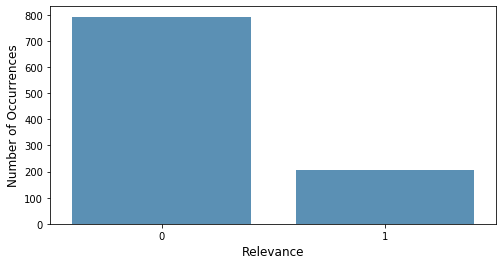

In [14]:
color = sns.color_palette()
classif = data['class_threshold3'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relevance', fontsize=12)
plt.show()

In [15]:
data['class_threshold3'].value_counts()

0    793
1    207
Name: class_threshold3, dtype: int64

# clear text
* use regex to clear repeated vogals.
* remove links

In [16]:
def clear_text(text):
    text = re.sub('a+', 'a', text)
    text = re.sub('e+', 'e', text)
    text = re.sub('i+', 'i', text)
    text = re.sub('o+', 'o', text)
    text = re.sub('u+', 'u', text)
    return text
#clear_text('nao goooosto diiiiisso')

In [17]:
data['text'] = data['text'].apply(lambda x: clear_text(x.lower()))

# tokenize
using TweetTokenizer from nltk. Also gets lowercase text.

In [18]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [19]:
data['tokens'] = data['text'].apply(lambda x: tknzr.tokenize(x.translate(str.maketrans('', '', string.punctuation)).lower()))
data.head()['tokens']

0    [brasil, tera, 55, mil, militares, nas, ruas, ...
1    [depois, do, exercito, abandonar, o, combate, ...
2    [farmaceuticos, recebem, treinamento, sobre, d...
3    [farmaceuticos, recebem, treinamento, sobre, d...
4    [rt, g1, morador, do, df, faz, rap, da, dengue...
Name: tokens, dtype: object

In [20]:
#tfidf = TfidfVectorizer(analyzer='word')
counter = Counter()
for text in data['tokens']:
    counter.update(text)
tf_top = sorted(counter, key=counter.get)[-500:]

In [21]:
tf_top[-5:]

['o', 'zika', 'dengue', 'e', 'de']

In [22]:
#usando freq absoluta
def abs_tf(text, term):
    #text = text.lower().split()

    tf = 0
    for word in text:
        if word == term:
            tf += 1
    return tf

In [23]:
for term in tf_top:
    data[term] = 0
    data[term] = data['tokens'].apply(lambda text: abs_tf(text, term))

In [24]:
data.head()

,id,relevance,class,class_threshold3,text,text_original,date,tokens,municipios,sabado,...,em,da,rt,que,a,o,zika,dengue,e,de
0,699069305468551169,2,0,0,brasil tera 55 mil militares nas ruas para com...,Brasil terá 55 mil militares nas ruas para com...,2016-02-15,"[brasil, tera, 55, mil, militares, nas, ruas, ...",0,0,...,0,0,0,0,1,0,0,0,0,1
1,699164279472263170,3,0,1,depois do exercito abandonar o combate aos foc...,Depois do exército abandonar o combate aos foc...,2016-02-15,"[depois, do, exercito, abandonar, o, combate, ...",0,0,...,0,0,0,2,0,1,1,0,1,1
2,699264346304618496,1,0,0,farmaceuticos recebem treinamento sobre dengue...,Farmacêuticos recebem treinamento sobre dengue...,2016-02-15,"[farmaceuticos, recebem, treinamento, sobre, d...",0,0,...,0,0,0,0,0,0,1,1,2,1
3,699266282646994944,3,0,1,farmaceuticos recebem treinamento sobre dengue...,Farmacêuticos recebem treinamento sobre dengue...,2016-02-15,"[farmaceuticos, recebem, treinamento, sobre, d...",0,0,...,0,0,0,0,0,0,1,1,2,1
4,699315864122892288,0,0,0,rt @g1: morador do df faz 'rap da dengue': 'ag...,RT @g1: Morador do DF faz 'rap da dengue': 'Ag...,2016-02-15,"[rt, g1, morador, do, df, faz, rap, da, dengue...",0,0,...,0,1,1,0,0,0,0,1,0,0


# Data split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
data = data.rename(columns={"class": "y1", "class_threshold3": "y2"})

In [27]:
x_variables = data.columns[7:]
x_variables

Index(['tokens', 'municipios', 'sabado', 'vigilancia', 'voluntarios', 'es',
       'fora', 'lula', '30', 'causar',
       ...
       'em', 'da', 'rt', 'que', 'a', 'o', 'zika', 'dengue', 'e', 'de'],
      dtype='object', length=501)

In [28]:
#ys = data.iloc[:, 2:4]
y = data.loc[:, 'y2']
#y = data.iloc[:, 3:4]
X = data.iloc[:, 8:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0, shuffle=False)

In [29]:
X_train.head()

,municipios,sabado,vigilancia,voluntarios,es,fora,lula,30,causar,colombia,...,em,da,rt,que,a,o,zika,dengue,e,de
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


In [30]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: y2, dtype: int64

# Oversampling minority class
Tested only on 1 ML model

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_traincv_res, y_traincv_res = smote.fit_sample(X_train, y_train)

# Machine Learning, Baseline
Using Logistic regression and Random Forest as baselines

In [34]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)

#LogisticRegression()

# Specify the hyperparameter space
c_space = np.logspace(-5, 1, 20)
parameters = {'logreg__C': c_space, 
              'logreg__penalty': ['l1', 'l2'],
              'logreg__random_state':[42]}

# Instantiate the GridSearchCV object: cv
n_fold_cv = int(len(X_train)/4)
clf_logreg = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

# Fit to the training set
clf_logreg.fit(X_train, y_train)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_logreg.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_logreg.best_score_))


TUNED MODEL PARAMETERS:
 {'logreg__C': 1e-05, 'logreg__penalty': 'l2', 'logreg__random_state': 42}

TUNED RECALL:
 0.6161013824884792


In [37]:
logreg_best = clf_logreg.best_params_

#### repeat with oversampling

In [38]:
# Fit to the training set
clf_logreg.fit(X_traincv_res, y_traincv_res)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_logreg.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_logreg.best_score_))


TUNED MODEL PARAMETERS:
 {'logreg__C': 1e-05, 'logreg__penalty': 'l2', 'logreg__random_state': 42}

TUNED RECALL:
 0.8761384335154827


In [39]:
logreg_best_smote = clf_logreg.best_params_

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfc__max_features':[1, 2, "auto", "log2", None],
              'rfc__n_estimators':[300],
              'rfc__random_state':[42]}

# Instantiate the GridSearchCV object: clf_rforest
clf_rforest = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

# Fit to the training set
clf_rforest.fit(X_train, y_train)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_rforest.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_rforest.best_score_))


TUNED MODEL PARAMETERS:
 {'rfc__max_features': None, 'rfc__n_estimators': 300, 'rfc__random_state': 42}

TUNED RECALL:
 0.2781459293394777


# Machine Learning, other models

### svm

In [40]:
from sklearn import svm

In [41]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('svc', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'svc__kernel': ['linear', 'poly'],
              'svc__C': np.linspace(0.1,2,10),
              'svc__degree': [2,3,4],
              'svc__gamma': np.logspace(-5, 0, 10),
              'svc__random_state':[42]}

clf_svc = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

clf_svc.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_svc.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_svc.best_score_))


TUNED MODEL PARAMETERS:
 {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 1e-05, 'svc__kernel': 'linear', 'svc__random_state': 42}

TUNED RECALL:
 0.4369892473118279


### adaboost

In [42]:
from sklearn.ensemble import AdaBoostClassifier

In [43]:
steps = [('scaler', StandardScaler()),
         ('abc', AdaBoostClassifier())]

pipeline = Pipeline(steps)

parameters = {'abc__n_estimators': [300],
              'abc__random_state':[42]}

clf_abc = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

clf_abc.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_abc.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_abc.best_score_))


TUNED MODEL PARAMETERS:
 {'abc__n_estimators': 300, 'abc__random_state': 42}

TUNED RECALL:
 0.41133640552995393


### gradient boosting

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
steps = [('scaler', StandardScaler()),
         ('gbc', GradientBoostingClassifier())]

pipeline = Pipeline(steps)

parameters = {'gbc__n_estimators': [300],
              'gbc__random_state':[42]}


clf_gbc = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

clf_gbc.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_gbc.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_gbc.best_score_))


TUNED MODEL PARAMETERS:
 {'gbc__n_estimators': 300, 'gbc__random_state': 42}

TUNED RECALL:
 0.2784362519201229


### xgboost

In [60]:
import xgboost as xgb

In [62]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'reg:squarederror'
params['eval_metric'] = 'aucpr'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-aucpr:0.781392	valid-aucpr:0.43255
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
[10]	train-aucpr:0.874452	valid-aucpr:0.477074
[20]	train-aucpr:0.910408	valid-aucpr:0.485025
[30]	train-aucpr:0.93012	valid-aucpr:0.484355
[40]	train-aucpr:0.954417	valid-aucpr:0.528684
[50]	train-aucpr:0.964534	valid-aucpr:0.558366
[60]	train-aucpr:0.973277	valid-aucpr:0.558642
[70]	train-aucpr:0.979824	valid-aucpr:0.566415
[80]	train-aucpr:0.984185	valid-aucpr:0.572223
[90]	train-aucpr:0.986668	valid-aucpr:0.581712
[100]	train-aucpr:0.989121	valid-aucpr:0.594533
[110]	train-aucpr:0.990518	valid-aucpr:0.596883
[120]	train-aucpr:0.991105	valid-aucpr:0.598247
[130]	train-aucpr:0.991645	valid-aucpr:0.600717
[140]	train-aucpr:0.992127	valid-aucpr:0.601766
[150]	train-aucpr:0.9924	valid-aucpr:0.599034
[160]	train-aucpr:0.992463	valid-aucpr:0.599031
[170]	train-aucpr:0.992761	valid-aucpr:0.599921
[180

In [63]:
def use_threshold(value):
    if value > 0.2: value = 1
    else: value = 0
    return value

In [64]:
p_test = bst.predict(d_test)
y_pred = np.array(list((map(use_threshold, p_test))))

In [65]:
accuracy_score(y_test, y_pred)

0.7533333333333333

In [66]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83       244
           1       0.41      0.75      0.53        56

    accuracy                           0.75       300
   macro avg       0.67      0.75      0.68       300
weighted avg       0.83      0.75      0.78       300



# Plot results

In [49]:
dic_results = {}
dic_results['logistic regression']= clf_logreg.best_score_
dic_results['random forest']= clf_rforest.best_score_
dic_results['svm']= clf_svc.best_score_
dic_results['adaboost']= clf_abc.best_score_
dic_results['gradient boosting']= clf_gbc.best_score_

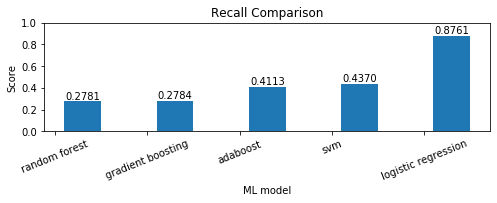

In [61]:
import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Score')
ax.set_xlabel('ML model')
ax.set_ylim(ymin=0.0,ymax = 1)
ax.set_title("Recall Comparison")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=22)

plt.show()

# calculate final quality with a test set
So we see that the best validated model is Logistic Regression. We will now test it on the test set. We could also compare with other models with their respective best params.

### transform data

In [51]:
#transform X_train
scale = StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)

#transform X_test
scale = StandardScaler().fit(X_test)
X_test_scaled = scale.transform(X_test)

### get best params of regressor
this was previously obtained during cross validation step

In [52]:
params_normal = {}
for k,v in logreg_best.items():
    k = k[8:]
    params_normal[k] = v
params_normal

{'C': 1e-05, 'penalty': 'l2', 'random_state': 42}

In [53]:
#instantiate regressor with best params
params = params_normal
clf_logreg_validated = LogisticRegression(C = params['C'], penalty = params['penalty'], random_state = params['random_state'])

clf_logreg_validated.fit(X_train_scaled, y_train)
y_pred = clf_logreg_validated.predict(X_test_scaled)

### calculate accuracy on test set

In [54]:
accuracy_score(y_test, y_pred)

0.8333333333333334

### classification report

In [55]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       244
           1       0.55      0.61      0.58        56

    accuracy                           0.83       300
   macro avg       0.73      0.75      0.74       300
weighted avg       0.84      0.83      0.84       300



### repeat for oversampled model

In [56]:
params_smote = {}
for k,v in logreg_best_smote.items():
    k = k[8:]
    params_smote[k] = v
params_smote

{'C': 1e-05, 'penalty': 'l2', 'random_state': 42}

In [57]:
#instantiate regressor with best params
params = params_smote
clf_logreg_validated = LogisticRegression(C = params['C'], penalty = params['penalty'], random_state = params['random_state'])

clf_logreg_validated.fit(X_train_scaled, y_train)
y_pred = clf_logreg_validated.predict(X_test_scaled)

In [58]:
accuracy_score(y_test, y_pred)

0.8333333333333334

In [59]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       244
           1       0.55      0.61      0.58        56

    accuracy                           0.83       300
   macro avg       0.73      0.75      0.74       300
weighted avg       0.84      0.83      0.84       300



# draft

### temp test with rfc

In [570]:
params = {}
for k,v in clf_rforest.best_params_.items():
    k = k[5:]
    params[k] = v
params

{'max_features': None, 'n_estimators': 300, 'random_state': 42}

In [571]:
#transform X_train
scale = StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)

#transform X_test
scale = StandardScaler().fit(X_test)
X_test_scaled = scale.transform(X_test)

#instantiate regressor with best params
clf_rfc_validated = RandomForestClassifier(max_features = params['max_features'], n_estimators = params['n_estimators'], random_state = params['random_state'])

#fit regressor
clf_rfc_validated.fit(X_train_scaled, y_train)

#do prediction on test set
y_pred = clf_rfc_validated.predict(X_test_scaled)

### calculate accuracy on test set

In [572]:
accuracy_score(y_test, y_pred)

0.8160919540229885

### classification report

In [573]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       142
           1       0.50      0.16      0.24        32

    accuracy                           0.82       174
   macro avg       0.67      0.56      0.57       174
weighted avg       0.77      0.82      0.77       174

